In [74]:
%load_ext autoreload
%autoreload 2
import pickle, numpy as np
import sys
import torch as t
sys.path.append("../../")
import matplotlib.pyplot as plt
from som.intopolate import weighted_log

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
filtered_dataset = pickle.load(open('build/data_filtered.pkl','rb'))
nc = pickle.load(open('build/prototype/nc.dat','rb'))
wc = pickle.load(open('build/prototype/wc.dat','rb'))
idx2word = pickle.load(open('build/prototype/idx2word.dat','rb'))
word2idx = pickle.load(open('build/prototype/word2idx.dat','rb'))

In [88]:
print(len(filtered_dataset))
print(filtered_dataset[:3])

1072
[('17.0', ['east', 'asia', 'summit', 'and', 'the', 'th', 'asean', 'summit', 'held', 'on']), ('2005.0', ['top', 'model', 'which', 'premiered', 'in', 'he', 'was', 'originally', 'cast', 'by']), ('24.0', ['titles', 'anywhere', 'any', 'time', 'on', 'basis', 'which', 'means', 'that', 'an'])]


# Test

In [134]:
idx2vec=pickle.load(open('build/prototype/idx2vec.dat','rb'))
trained_prototypes=pickle.load(open('build/prototype/trained_prototypes.dat','rb'))
prototypes=trained_prototypes['prototypes']
prototypes2vec=trained_prototypes['i_embedding']








In [135]:
transformed_protp=t.tensor(t.from_numpy(prototypes), dtype=t.float32).apply_(weighted_log).view(-1,1)
def get_numeral_embed_weights_batch(numerals,transformed_protp,fn=weighted_log):
    """
    :param numerals: tensor of numerals
    :return: weights matrix
    """
    # TODO: can we get a function that can easily be gpu_accelerated?
    numerals.apply_(fn)
    l_numerals = numerals.size()[0]
    l_prototypes = transformed_protp.size()[0]

    min_margin =  t.tensor(0.0001, dtype=t.float32)
    transformed_prototypes_batch =transformed_protp.expand(l_prototypes, l_numerals)

    prototype_weights = 1 / t.max(t.abs(transformed_prototypes_batch - numerals),min_margin)
    prototype_weights /= t.sum(prototype_weights, 0)
    return prototype_weights # [prototype_size x num_of_numerals]


In [144]:
# c=np.array(list(map(float, nc.values())))
numerals = np.array([float(i[0]) for i in filtered_dataset])

In [145]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

In [146]:
prototype_weights=get_numeral_embed_weights_batch(t.tensor(t.from_numpy(numerals),dtype=t.float),transformed_protp)
numeral_embed = t.matmul(prototype_weights.transpose(0,1),t.from_numpy(prototypes2vec))

In [147]:
def evaluate(kbest):
    right = 0
    for i in filtered_dataset:
        s = np.zeros((len(numerals),))
        for j in i[1]:
            wordvec = idx2vec[word2idx[j]]
            score = np.dot(wordvec, np.array(numeral_embed).T)
            s += np.log(sigmoid(score))
        score = s
#         token_weight=np.zeros((100,))
#         for j in i[1]:
#             token_weight += idx2vec[word2idx[j]]
#         score=np.dot(token_weight,np.array(numeral_embed).T)
        nn=np.argsort(score)[-kbest:]

        if float(i[0]) in numerals[nn]:
            right += 1
    return right/len(filtered_dataset)
#     print(numerals[score.argmax()],score.argmax(),score[1627],score[170154])
#     print(np.min(abs(np.array(numerals[nn])-np.array(float(i[0])))))
#     print( numerals[nn],float(i[0]))


In [148]:
a = [10, 20, 50, 100, 200, 500, 800]

In [149]:
portion = [i/len(filtered_dataset) for i in a]
res = [evaluate(i) for i in a]

In [150]:
import matplotlib.pyplot as plt

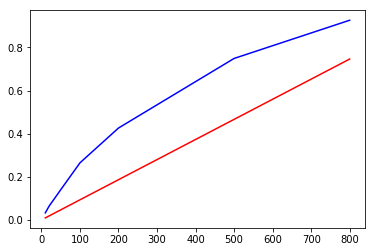

In [151]:
plt.plot(a, portion, 'r')
plt.plot(a, res, 'b')
plt.show()